In [271]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [272]:
## Import the data file
tattiesraw = pd.read_excel("Veg dataset raw.xlsx", sheet_name='Red_Potatoes')
tattiesraw['Date'] = pd.to_datetime(tattiesraw['Date'])

## Set the index column
tattiesraw.set_index('Date', inplace=True)
print(tattiesraw)

           Main Ingredient  Average Price
Date                                     
2013-06-16      Potato Red           20.5
2013-06-17      Potato Red           20.5
2013-06-18      Potato Red           19.5
2013-06-19      Potato Red           20.5
2013-06-20      Potato Red           20.5
...                    ...            ...
2021-05-09      Potato Red           36.5
2021-05-10      Potato Red           36.5
2021-05-11      Potato Red           36.5
2021-05-12      Potato Red           36.0
2021-05-13      Potato Red           36.0

[2746 rows x 2 columns]


In [273]:
print(tattiesraw.describe())

       Average Price
count    2746.000000
mean       35.419337
std        15.210699
min        15.000000
25%        25.000000
50%        32.000000
75%        41.000000
max       113.500000


In [274]:
## Check for null values and data types
tattiesraw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2746 entries, 2013-06-16 to 2021-05-13
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Main Ingredient  2746 non-null   object 
 1   Average Price    2746 non-null   float64
dtypes: float64(1), object(1)
memory usage: 64.4+ KB


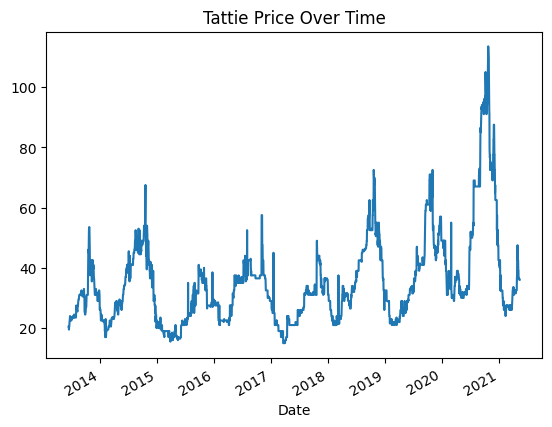

In [275]:
## Plot the time series
tattiesraw['Average Price'].plot(title='Tattie Price Over Time')
plt.show()

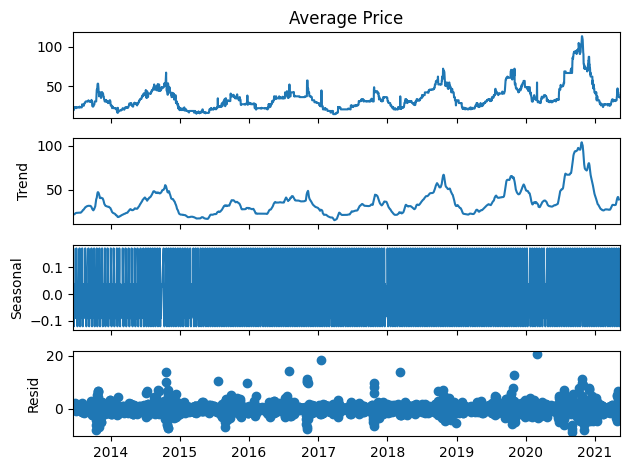

In [276]:
## Decompose the data to observe for trend, seasonality, and residuals
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(tattiesraw['Average Price'], model='additive', period=12)

# Plot the decomposition
decomposition.plot()
plt.show()


<Axes: xlabel='Date'>

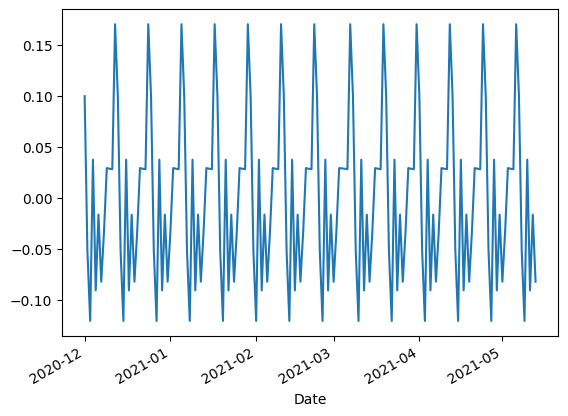

In [277]:
# Zoom in on seasonality to confirm seasonality
decomposition.seasonal.loc['2020-12':'2021-12'].plot()

In [278]:
## The decompoisition demonstrates a long-term increase in the average prices. There are certain points of price acceleration and price deceleration. The seasonal plot appears very flat, indicating there isn't strong seasonal variation. The residual plot doesn't indicate any specific pattern, with fluctuations being scattered and therefore random.

# The primary driver for average price of tatties appears to be a general increase over time, with very little impact from seasonsality, not any systematic error.

# Seasonality is confirmed as potentially quarterly

## Following these observations, it would be best to proceed with an ARIMA model.

In [279]:
## Check for outliers
from scipy.stats import zscore

# Calculate Z-scores
tattiesraw['z_score'] = zscore(tattiesraw['Average Price'])

# Define a threshold for identifying outliers. 3 is a standard threshold.
threshold = 3

# Detect outliers
outliers = tattiesraw[abs(tattiesraw['z_score']) > threshold]
print("Outliers detected:")
print(outliers)

Outliers detected:
           Main Ingredient  Average Price   z_score
Date                                               
2020-09-04      Potato Red           82.5  3.095797
2020-09-05      Potato Red           86.5  3.358818
2020-09-06      Potato Red           85.0  3.260185
2020-09-07      Potato Red           85.0  3.260185
2020-09-08      Potato Red           87.5  3.424573
...                    ...            ...       ...
2020-11-27      Potato Red           82.5  3.095797
2020-11-28      Potato Red           82.5  3.095797
2020-11-29      Potato Red           87.5  3.424573
2020-11-30      Potato Red           87.5  3.424573
2020-12-01      Potato Red           87.5  3.424573

[62 rows x 3 columns]


In [280]:
## 2.25% of the data has been identified as an outlier when using a threshold of 3 standard deviations from the mean. 
## This appears to be a significant proportion of the original dataset and it is important to check if these are true outliers or if they are indicitive of a sudden change in the trend.

outliers.info()
outliers.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 2020-09-04 to 2020-12-01
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Main Ingredient  62 non-null     object 
 1   Average Price    62 non-null     float64
 2   z_score          62 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.9+ KB


,Average Price,z_score
count,62.000000,62.000000
mean,94.790323,3.903949
std,6.706706,0.441001
min,82.500000,3.095797
25%,91.500000,3.687594
50%,94.000000,3.851982
75%,97.000000,4.049247
max,113.500000,5.134208


In [281]:
## The outliers appear to cover a period of three months towards the latter end of the raw dataset. This correlates with the Covid-19 pandemic, and indicates that these are significant and real. 
##Therefore, we will not remove these outliers, but instead make note of them. 

In [282]:
## Check data quality

tattiesraw.info()
print(tattiesraw.describe())
print(tattiesraw.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2746 entries, 2013-06-16 to 2021-05-13
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Main Ingredient  2746 non-null   object 
 1   Average Price    2746 non-null   float64
 2   z_score          2746 non-null   float64
dtypes: float64(2), object(1)
memory usage: 85.8+ KB
       Average Price       z_score
count    2746.000000  2.746000e+03
mean       35.419337  2.484053e-16
std        15.210699  1.000182e+00
min        15.000000 -1.342677e+00
25%        25.000000 -6.851253e-01
50%        32.000000 -2.248391e-01
75%        41.000000  3.669575e-01
max       113.500000  5.134208e+00
           Main Ingredient  Average Price   z_score
Date                                               
2013-06-16      Potato Red           20.5 -0.981024
2013-06-17      Potato Red           20.5 -0.981024
2013-06-18      Potato Red           19.5 -1.046779
2013-06-19      Po

In [283]:
print(tattiesraw.head())

           Main Ingredient  Average Price   z_score
Date                                               
2013-06-16      Potato Red           20.5 -0.981024
2013-06-17      Potato Red           20.5 -0.981024
2013-06-18      Potato Red           19.5 -1.046779
2013-06-19      Potato Red           20.5 -0.981024
2013-06-20      Potato Red           20.5 -0.981024


In [284]:
tatties = tattiesraw.drop(['Main Ingredient', 'z_score'], axis=1)

In [285]:
## As highlighted above, the data has an upwards trend and there is seasonality present. 
## Let's confirm that it is not stationary using the Augmented Dickey Fuller test.

from statsmodels.tsa.stattools import adfuller
result = adfuller(tatties)

# Extract and print the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Interpret the result
if result[1] <= 0.05:
    print("The time series is likely stationary (reject null hypothesis)")
else:
    print("The time series is likely non-stationary (fail to reject null hypothesis)")



ADF Statistic: -3.058058333393299
p-value: 0.0298168162768219
Critical Values: {'1%': -3.4327353600205757, '5%': -2.862593880583324, '10%': -2.5673310144635737}
The time series is likely stationary (reject null hypothesis)


In [286]:
# Initial attempts have demonstrated the kernel runs too slowly with daily data. Therefore, for ease, let's adjust to monthly data, using the average.

monthlytatties = tatties.resample('M').mean()

print(monthlytatties)

            Average Price
Date                     
2013-06-30      21.772727
2013-07-31      23.480000
2013-08-31      28.142857
2013-09-30      30.360000
2013-10-31      36.777778
...                   ...
2021-01-31      34.435484
2021-02-28      26.839286
2021-03-31      27.783333
2021-04-30      34.083333
2021-05-31      38.846154

[96 rows x 1 columns]


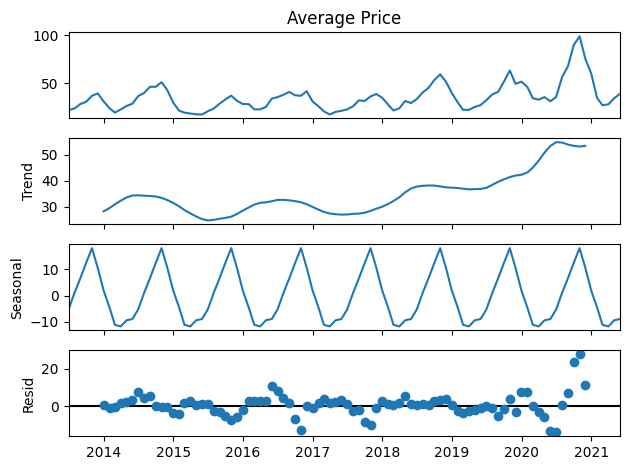

In [287]:
## Decompose the data to observe for trend, seasonality, and residuals
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(monthlytatties['Average Price'], model='additive', period=12)

# Plot the decomposition
decomposition.plot()
plt.show()

<Axes: xlabel='Date'>

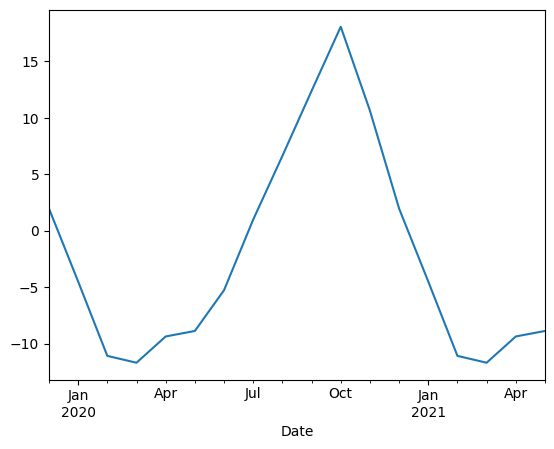

In [288]:
# Zoom in on seasonality to confirm seasonality
decomposition.seasonal.loc['2019-12':'2021-12'].plot()

Trend: fluctuating trend with general upward movement. 

Seasonality: Stationary, every 6 weeks.

Residuals:  Small, close to zero residuals imply trend and seasonality was sufficiently separated.

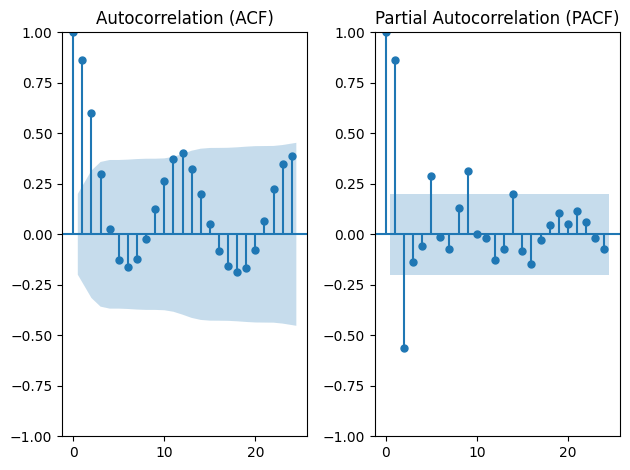

In [352]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.subplot(1, 2, 1)
plot_acf(monthlytatties, lags=24, ax=plt.gca())
plt.title('Autocorrelation (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(monthlytatties, lags=24, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.show()

In [353]:
# Check stationarity of weekly data
from statsmodels.tsa.stattools import adfuller
monthlyresult = adfuller(monthlytatties)

# Extract and print the results
print('ADF Statistic:', monthlyresult[0])
print('p-value:', monthlyresult[1])
print('Critical Values:', monthlyresult[4])

# Interpret the result
if monthlyresult[1] <= 0.05:
    print("The time series is likely stationary (reject null hypothesis)")
else:
    print("The time series is likely non-stationary (fail to reject null hypothesis)")

ADF Statistic: -0.45690753333255624
p-value: 0.9001549480497195
Critical Values: {'1%': -3.5117123057187376, '5%': -2.8970475206326833, '10%': -2.5857126912469153}
The time series is likely non-stationary (fail to reject null hypothesis)


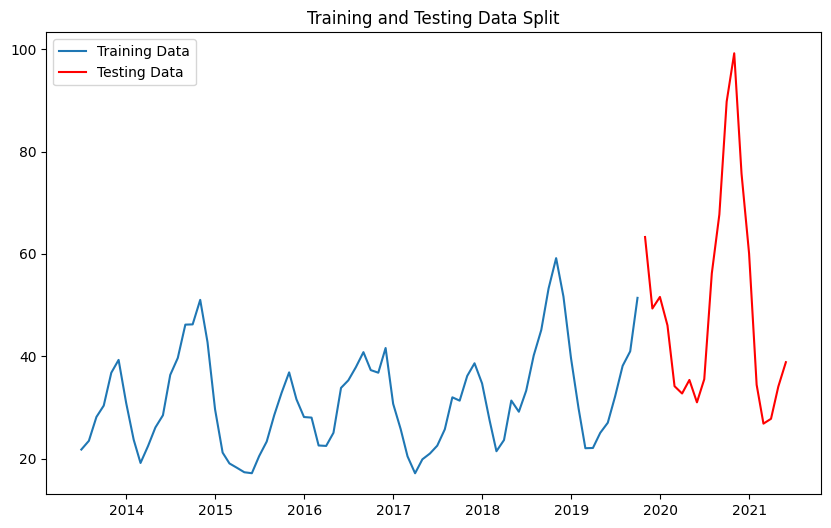

In [354]:
## Split the data into training and testing sets

## Let 80% of the data be the training data, with the remaining 20% reserved for testing
train_size = int(len(monthlytatties) * 0.8)
tatties_train, tatties_test = monthlytatties[:train_size], monthlytatties[train_size:]
tatties_train = tatties_train.asfreq('M')
tatties_test = tatties_test.asfreq('M')

# Plot the split to visualize
plt.close('all')
plt.figure(figsize=(10, 6))
plt.plot(tatties_train.index, tatties_train, label='Training Data')
plt.plot(tatties_test.index, tatties_test, label='Testing Data', color='red')
plt.legend()
plt.title('Training and Testing Data Split')
plt.show()


In [355]:
## Now to perform the ARIMA model

## Import the necessary libraries
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller

In [357]:
# Fit the model using auto ARIMA
arima_model = auto_arima(tatties_train['Average Price'],d=1, D=0,
                         m=6, seasonal = True,
                         trace = True,
                         supress_warnings=True,
                         stepwise = False, n_jobs=-1
                        )                     

# Print the summary of the best model found
arima_model.summary()


Best model:  ARIMA(0,1,1)(2,0,1)[6] intercept
Total fit time: 23.802 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   76
Model:             SARIMAX(0, 1, 1)x(2, 0, 1, 6)   Log Likelihood                -209.543
Date:                           Sat, 03 May 2025   AIC                            431.086
Time:                                   21:42:25   BIC                            444.991
Sample:                               06-30-2013   HQIC                           436.638
                                    - 09-30-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4891      1.118      0.437      0.662      -1.703       2.681
ma.L1          0.3134      0.134      2.335      0.020       0.050       0.576
ar.S.L6       -0.6689      0.172     -3.883      0.000      -1.007      -0.331
ar.S.L12       0.3077      0.155      1.985      0.047       0.004       0.612
ma.S.L6        0.7771      0.132      5.902      0.000       0.519       1.035
sigma2        13.9756      2.692      5.191      0.000       8.699      19.252
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.96   Prob(JB):                         0.83
Heteroskedasticity (H):               1.45   Skew:                            -0.16
Prob(H) (two-sided):                  0.36   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [358]:
## Use the model to predict values
prediction_tatties = pd.DataFrame(arima_model.predict(n_periods=len(tatties_test)), index=tatties_test.index, columns=['predicted average price'])
print(prediction_tatties.head())

            predicted average price
Date                               
2019-10-31                55.503278
2019-11-30                54.103363
2019-12-31                48.470588
2020-01-31                43.332944
2020-02-29                38.193731


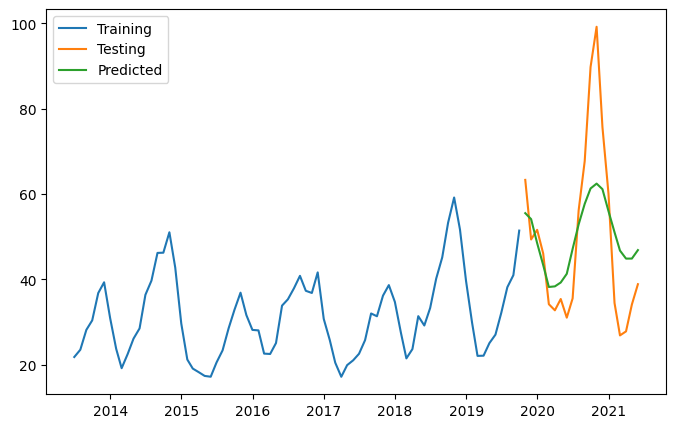

In [359]:
# Plot the model-predicted values against the actual values i.e. the test data set
plt.close('all')
plt.figure(figsize=(8,5))
plt.plot(tatties_train,label="Training")
plt.plot(tatties_test,label="Testing")
plt.plot(prediction_tatties,label="Predicted")
plt.legend(loc = 'upper left')
plt.show()

In [365]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
tatties_test = tatties_test.copy() # create a copy to not override the original data
tatties_test['predicted average price'] = prediction_tatties
r2 = r2_score(tatties_test['Average Price'], tatties_test['predicted average price'])
mae = mean_absolute_error(tatties_test['Average Price'], tatties_test['predicted average price'])
mape = np.mean(np.abs((tatties_test['Average Price']-tatties_test['predicted average price'])/tatties_test['Average Price']))*100
print(f'R-squared: {r2}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

R-squared: 0.5115985285624676
MAE: 11.168274272537245
MAPE: 24.555885903837098


C:\Users\HannahFarrell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


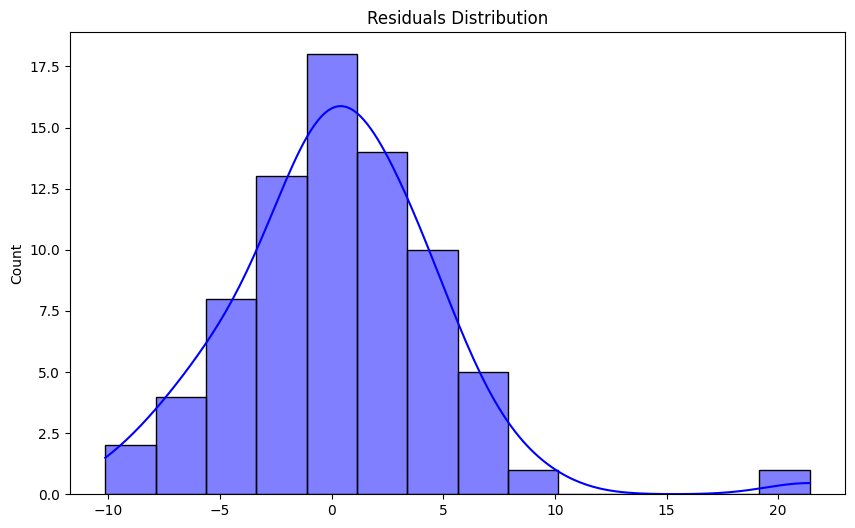

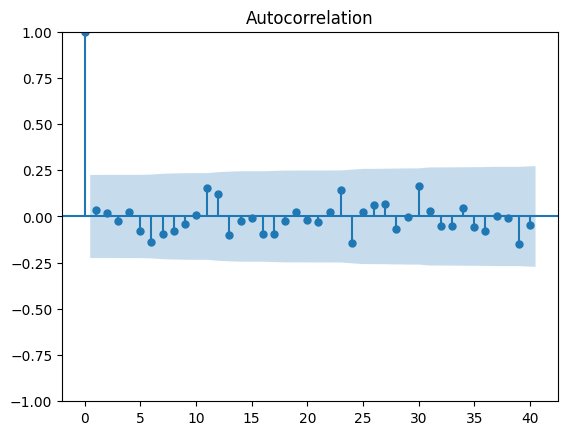

In [366]:
## Perform residual analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Residuals of the model
residuals = arima_model.resid()

# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Residuals Distribution')
plt.show()

# Plot ACF of residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=40)
plt.show()


In [367]:
# Fix index frequency
tatties_train = tatties_train.asfreq('M')
tatties_test = tatties_test.asfreq('M')

# Confirm forecast works
future_forecast = arima_model.predict(n_periods=len(tatties_test)+12)
display(future_forecast)

# Generate future dates
last_date = tatties_test.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='M')

# Combine
forecast_df = pd.DataFrame({'Forecast Price': future_forecast}, index=future_dates)
display(forecast_df)

2019-10-31    55.503278
2019-11-30    54.103363
2019-12-31    48.470588
2020-01-31    43.332944
2020-02-29    38.193731
2020-03-31    38.336736
2020-04-30    39.245826
2020-05-31    41.281508
2020-06-30    47.118299
2020-07-31    52.885292
2020-08-31    57.684321
2020-09-30    61.293184
2020-10-31    62.431737
2020-11-30    61.128333
2020-12-31    55.979731
2021-01-31    51.030184
2021-02-28    46.727642
2021-03-31    44.846710
2021-04-30    44.853958
2021-05-31    46.841357
2021-06-30    52.570584
2021-07-31    58.145182
2021-08-31    62.989117
2021-09-30    65.846947
2021-10-31    66.681556
2021-11-30    65.440148
2021-12-31    60.512491
2022-01-31    55.749524
2022-02-28    51.674411
2022-03-31    49.673036
2022-04-30    49.606074
2022-05-31    51.537145
Freq: M, dtype: float64

,Forecast Price
2021-06-30,52.570584
2021-07-31,58.145182
2021-08-31,62.989117
2021-09-30,65.846947
2021-10-31,66.681556
2021-11-30,65.440148
2021-12-31,60.512491
2022-01-31,55.749524
2022-02-28,51.674411
2022-03-31,49.673036


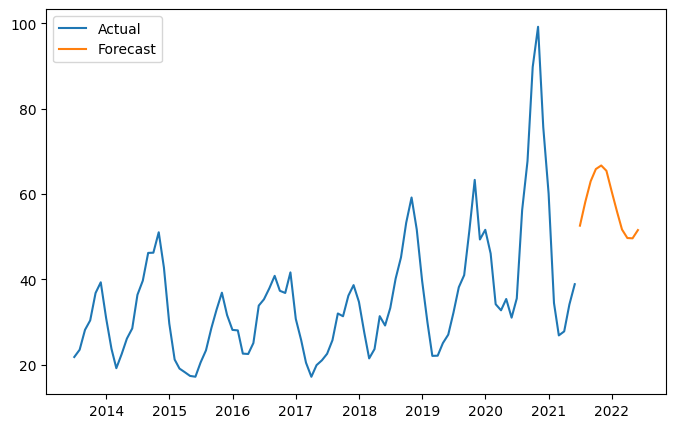

In [368]:
# Plot the model-predicted values against the actual values i.e. the test data set
plt.close('all')
plt.figure(figsize=(8,5))
plt.plot(monthlytatties,label="Actual")
plt.plot(forecast_df,label="Forecast")
plt.legend(loc = 'upper left')
plt.show()

In [369]:
## Combine actual values with predicted values in the data frame

merged_df = pd.merge(monthlytatties, forecast_df, left_index=True, right_index=True, how='outer')
display(merged_df.tail(24))

,Average Price,Forecast Price
2020-06-30,35.516667,NaN
2020-07-31,56.200000,NaN
2020-08-31,67.709677,NaN
2020-09-30,89.766667,NaN
2020-10-31,99.206897,NaN
2020-11-30,75.683333,NaN
2020-12-31,60.080645,NaN
2021-01-31,34.435484,NaN
2021-02-28,26.839286,NaN
2021-03-31,27.783333,NaN


In [370]:
## Export to CSV
merged_df.to_csv('tatties_model_results.csv', index=True)
print(f'Data exported successfully')

Data exported successfully
